In [1]:
output_folder_clipped = r"/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/LST to AT/Clipped"  # UPDATE THIS
boundary_path = r"/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/Final shapefile/흑석동 Area Final Shapefile.gpkg"  # UPDATE THIS

Original data: 275,773 records

Identifying river pixels to exclude...
Pixels to exclude: 494
Data after excluding river: 238,210 records (86.4%)

Partial Correlation

SPRING SEASON ANALYSIS

Partial Correlations:
  Building Ratio      : +0.257
  FSI                 : +0.154
  GSI                 : +0.287
  NDVI                : -0.363
  Building Volume     : +0.186
  Weighted Height     : -0.084

Partial Correlations:
  Building Ratio      : +0.223
  FSI                 : +0.106
  GSI                 : +0.324
  NDVI                : -0.323
  Building Volume     : +0.167
  Weighted Height     : -0.124

Partial Correlations:
  Building Ratio      : +0.183
  FSI                 : +0.068
  GSI                 : +0.351
  NDVI                : -0.284
  Building Volume     : +0.146
  Weighted Height     : -0.155

SUMMER SEASON ANALYSIS

Partial Correlations:
  Building Ratio      : +0.334
  FSI                 : +0.184
  GSI                 : +0.351
  NDVI                : -0.452
  Building 

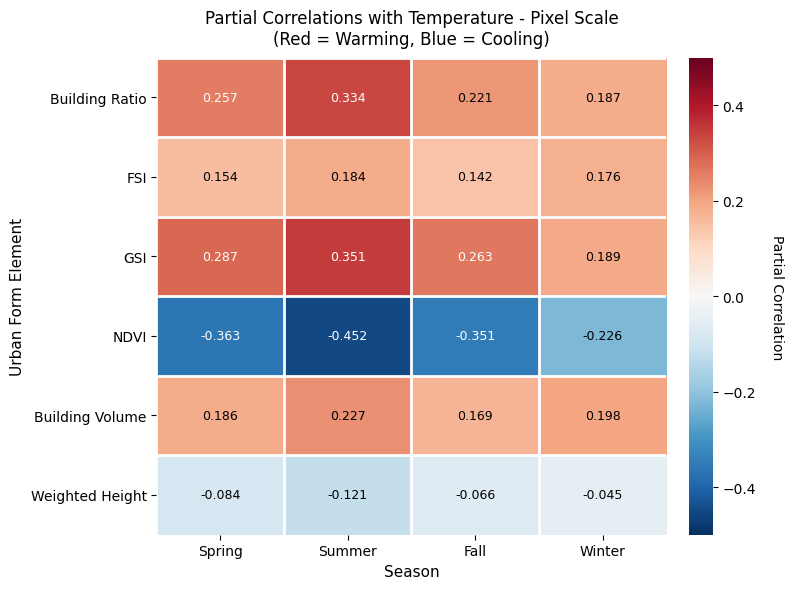

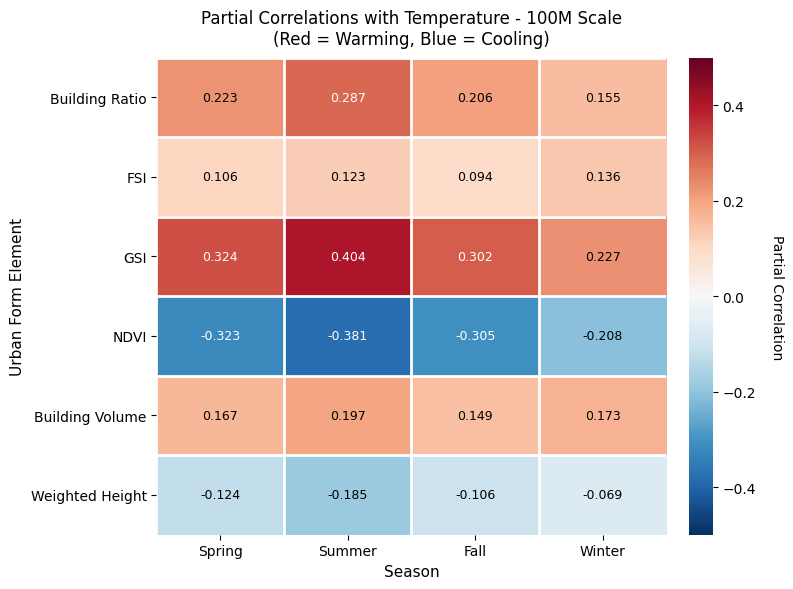

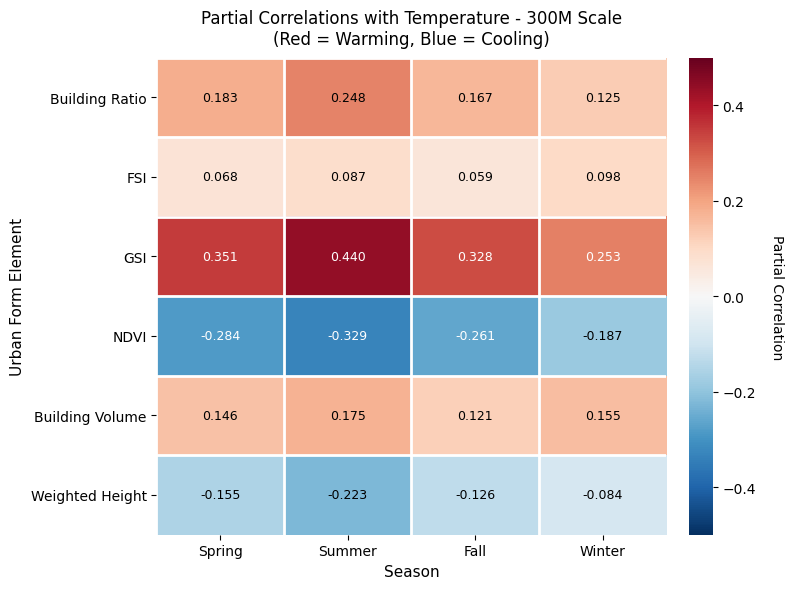

In [2]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv(os.path.join(output_folder_clipped, "final_analysis_dataset_complete.csv"))
print(f"Original data: {len(df):,} records")

# Load the pixel grid
pixel_grid = gpd.read_file(os.path.join(output_folder_clipped, "pixel_grid_study_area.shp"))

# Load the exclusion shapefile
exclusion_path = r"/Users/geunchansong/Documents/TU:d/Year 2/Graduation Thesis/LST to AT/River exclusion.gpkg"  # UPDATE THIS PATH
exclusion_area = gpd.read_file(exclusion_path)

# Ensure same CRS
if exclusion_area.crs != pixel_grid.crs:
    exclusion_area = exclusion_area.to_crs(pixel_grid.crs)

# Identify pixels to exclude
print("\nIdentifying river pixels to exclude...")
pixels_to_exclude = []

for idx, pixel in pixel_grid.iterrows():
    if any(pixel.geometry.intersects(excl_geom) for excl_geom in exclusion_area.geometry):
        pixels_to_exclude.append(pixel['pixel_id'])

print(f"Pixels to exclude: {len(pixels_to_exclude)}")

# Filter the data
df_no_river = df[~df['pixel_id'].isin(pixels_to_exclude)].copy()
print(f"Data after excluding river: {len(df_no_river):,} records ({len(df_no_river)/len(df)*100:.1f}%)")

# Partial correlation function
def calculate_partial_correlation(df, target, variable, control_vars):
    """Calculate partial correlation"""
    cols_needed = [target, variable] + control_vars
    clean_df = df[cols_needed].dropna()
    
    if len(clean_df) < 30:
        return np.nan, np.nan
    
    X_control = clean_df[control_vars]
    y = clean_df[target]
    
    model1 = LinearRegression()
    model1.fit(X_control, y)
    residuals_y = y - model1.predict(X_control)
    
    x = clean_df[variable]
    model2 = LinearRegression()
    model2.fit(X_control, x)
    residuals_x = x - model2.predict(X_control)
    
    if len(residuals_x) > 0 and np.std(residuals_x) > 0 and np.std(residuals_y) > 0:
        r, p_value = stats.pearsonr(residuals_x, residuals_y)
        return r, p_value
    else:
        return np.nan, np.nan

# Define scales
scales = {
    'Pixel': ['NDVI_pixel', 'Building_Ratio_pixel', 'Weighted_Height_pixel', 
              'Building_Volume_pixel', 'FSI_pixel', 'GSI_pixel'],
    '100M': ['NDVI_100m', 'Building_Ratio_100m', 'Weighted_Height_100m', 
             'volume_density_100m', 'FSI_100m', 'GSI_100m'],
    '300M': ['NDVI_300m', 'Building_Ratio_300m', 'Weighted_Height_300m', 
             'Building_Volume_300m', 'FSI_300m', 'GSI_300m']
}

print("\n" + "="*80)
print("Partial Correlation")
print("="*80)

# Run analysis for each season and scale
all_partial_results = []
seasons = ['spring', 'summer', 'fall', 'winter']

for season in seasons:
    print(f"\n{'='*60}")
    print(f"{season.upper()} SEASON ANALYSIS")
    print(f"{'='*60}")
    
    season_data = df_no_river[df_no_river['season'] == season].copy()
    
    for scale_name, scale_vars in scales.items():
        analysis_data = season_data[['temperature'] + scale_vars].dropna()
        
        if len(analysis_data) > 100:
            X = analysis_data[scale_vars]
            y = analysis_data['temperature'].values
            
            # Partial correlations
            print("\nPartial Correlations:")
            for i, var in enumerate(scale_vars):
                control_vars = [v for j, v in enumerate(scale_vars) if j != i]
                partial_r, p_value = calculate_partial_correlation(
                    analysis_data, 'temperature', var, control_vars
                )
                
                if not np.isnan(partial_r):
                    var_name = var.replace(f'_', '').replace(f'_{scale_name}', '').replace('_pixel', '')
                    print(f"  {var_name:20s}: {partial_r:+.3f}")
                    
                    # Store partial correlation results
                    all_partial_results.append({
                        'Season': season,
                        'Scale': scale_name,
                        'Variable': var_name,
                        'Partial_r': partial_r,
                        'P_value': p_value
                    })

partial_results_df = pd.DataFrame(all_partial_results)

partial_results_df.to_csv(os.path.join(output_folder_clipped, 'partial_correlation_results_no_river.csv'), index=False)

# Create partial correlation heatmaps for each scale
print("\n" + "="*80)
print("CREATING PARTIAL CORRELATION VISUALIZATIONS")
print("="*80)

for scale_name in ['pixel', '100m', '300m']:
    scale_data = partial_results_df[partial_results_df['Scale'] == scale_name]
    
    pivot_data = scale_data.pivot(index='Variable', columns='Season', values='Partial_r')
    
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(pivot_data, 
                cmap='RdBu_r', 
                center=0, 
                annot=True, 
                fmt='.3f',
                cbar_kws={'label': 'Partial Correlation'},
                vmin=-0.5, 
                vmax=0.5,
                linewidths=1)
    
    plt.title(f'Partial Correlations with Air Temperature - {scale_name.upper()} Scale \n(Red = Warming, Blue = Cooling)')
    plt.xlabel('Season')
    plt.ylabel('Urban Form Element')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder_clipped, f'partial_correlations_{scale_name}_scale_no_river.png'), dpi=300)
    plt.show()